In [1]:
!pip install pyunpack
!pip install patool

     |████████████████████████████████| 77 kB 6.3 MB/s  eta 0:00:01


In [18]:
#Importación de librerías necesarias

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from pyunpack import Archive
#from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [5]:
#Descompresión de las imágenes
os.mkdir('dataset')
Archive('TipoVehiculo.rar').extractall('dataset/')

In [19]:
print(tf.__version__)

2.1.0


In [7]:
#Se cargan los conjustos de imágenes y se reescalan

#train_dir = os.path.join('dataset/TipoVehiculo/Train')
#validation_dir = os.path.join('dataset/TipoVehiculo/Validation')
#test_dir = os.path.join('dataset/TipoVehiculo/test')

BATCH_SIZE = 15
IMG_SIZE = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1/255,
    validation_split = 0.3)

train_generator = train_datagen.flow_from_directory(
    directory='dataset/TipoVehiculo/Train',
    target_size=(224, 224),
    batch_size=15,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    directory='dataset/TipoVehiculo/Validation', # same directory as training data
    target_size=(224, 224),
    batch_size=15,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 8600 images belonging to 8 classes.
Found 1576 images belonging to 8 classes.


In [9]:
#Cambiar la escala de los valores de píxeles de las imágenes 

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
#rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5)

In [11]:
# Creación sel modelo base a partir del modelo previamente entrenado MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

#Congelar la base convolucional

base_model.trainable = False

In [12]:
#Agregar un encabezado de clasificación

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(8,activation='softmax',kernel_initializer='random_normal',bias_initializer='zeros')

In [28]:
#Usar aumento de datos

data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=30, horizontal_flip=True)


In [24]:
import json

def write_json(dataz, filename): 
    with open(filename,'w') as f: 
        json.dump(dataz, f, indent=4) 

data = []

with open('history.json', 'w') as file:
    json.dump(data, file, indent=4)

In [34]:
#Compilar el modelo y entrenarlo

#os.mkdir('modelos')
base_learning_rate = 0.005
history = []
contador = 0

for i in range(1,101):
    inputs = tf.keras.Input(shape=(224, 224, 3))
    #x = data_augmentation(inputs)
    x = preprocess_input(inputs)
    x = base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    mcp_save = ModelCheckpoint('modelos/transfer_learning_'+str(i)+'.hdf5', save_best_only=True, monitor='val_loss', mode='min',save_weights_only=False)
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    history.append(model.fit(train_generator,epochs=100,callbacks=[mcp_save],validation_data=validation_generator)) 

    with open('history.json') as json_file: 
        datay = json.load(json_file) 
     
        temp = datay

        y = { 'accuracy': history[contador].history['accuracy'],
            'loss': history[contador].history['val_loss']
            }            

        temp.append(y) 
    write_json(datay, 'history.json')  
 
    contador = contador + 1

    del model

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 574 steps, validate for 106 steps
Epoch 1/100
574/574 [==============================] - 167s 290ms/step - loss: 1.8883 - accuracy: 0.3864 - val_loss: 1.8905 - val_accuracy: 0.3871
Epoch 2/100
574/574 [==============================] - 168s 293ms/step - loss: 1.8881 - accuracy: 0.3864 - val_loss: 1.8905 - val_accuracy: 0.3871
Epoch 3/100
574/574 [==============================] - 168s 292ms/step - loss: 1.8880 - accuracy: 0.3864 - val_loss: 1.8904 - val_accuracy: 0.3871
Epoch 4/100
574/574 [==============================] - 176s 306ms/step - loss: 1.8880 - accuracy: 0.3864 - val_loss: 1.8904 - val_accuracy: 0.3871
Epoch 5/100
574/574 [==============================] - 173s 301ms/step - loss: 1.8879 - accuracy: 0.3864 - val_loss: 1.8904 - val_accuracy: 0.3871
Epoch 6/100
574/574 [==============================] - 174s 303ms/step - loss: 1.8879 - accuracy: 0.3864 - val_loss: 1.8904 - val_accuracy: 0.3871
Epoch 7/100
574/574 [===

/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


KeyboardInterrupt: 

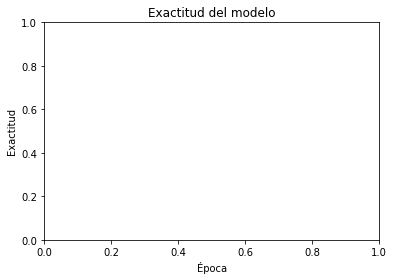

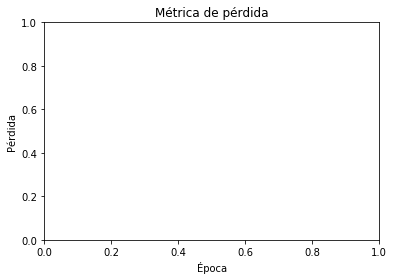

In [30]:
#Visualización de los resultados en gráficas

for i in range(len(history)):
  plt.plot(history[i].history['accuracy'])
plt.title('Exactitud del modelo')
plt.ylabel('Exactitud')
plt.xlabel('Época')
plt.show()
# "Loss"
for i in range(len(history)):
  plt.plot(history[i].history['val_loss'])
plt.title('Métrica de pérdida')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.show()

In [ ]:
#calculo del porcentajes de validación 

best_val_history = []
for i in range(1,3):
    model = load_model('modelos/transfer_learning_'+str(i)+'.hdf5')
    best_val_history.append(model.evaluate(validation_dataset))
    del model

In [ ]:
#Calculo de promedios de validación y pérdida 

prom_loss = 0.0;
prom_acc = 0.0;
for i in range(len(best_val_history)):
    prom_loss = prom_loss + best_val_history[i][0]
    prom_acc = prom_acc + best_val_history[i][1]

prom_loss = prom_loss / len(best_val_history)
prom_acc = prom_acc / len(best_val_history)

print(prom_loss)
print(prom_acc)

In [ ]:
import shutil
shutil.make_archive("modelos_tipo", 'zip', "modelos")